<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
결론적으로 LSTM은 seasonal에 주고 trend와 seasonal의 비율을 적당히 맞추는게 중요함<br>
&rightarrow; 이번에는 scaling 없이

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [20]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [21]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [22]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [23]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [24]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [25]:
tup= (1,2)
len(tup)

2

In [26]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [27]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [28]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        
        self.Linear_Trend = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
        
        output = trend_output+season_output
        
        return output,season_output,trend_output

In [29]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [30]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [31]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [32]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [33]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [34]:
torch.manual_seed(42)

In [35]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [36]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#        print(out)
        loss = criterion(out,tg)
    
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 17.90557881641918 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 15.13751689995481 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 15.294623643580934 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 14.619702498553789 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 14.409541911854031 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 13.342050652745401 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 15.227041550948044 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 12.633509990358888 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 15.7529714307067 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 20.19867779011702 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 9.21088527523496 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 9.947848788868331 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 9.664987787435496 %
Adjustin

In [37]:
print(ss_list[26])
print(tr_list[0])

tensor([[[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0125]],

        [[-0.0123]],

        [[-0.0123]],

        [[-0.0126]],

        [[-0.0123]],

        [[-0.0122]],

        [[-0.0123]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0125]],

        [[-0.0124]],

        [[-0.0125]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0124]],

        [[-0.0123]],

        [[-0.0123]],

        [[-0.0125]],

        [[-0.0124]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[0.6760]],

        [[0.6759]],

        [[0.6753]],

        [[0.6746]],

        [[0.6738]],

        [[0.6734]],

        [[0.6723]],

        [[0.6722]],

        [[0.6723]],

        [[0.6721]],

        [[0.6726]],

        [[0.6729]],

  

In [38]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.1130389125792135 %
SMAPE 0.07606931474674639 %
SMAPE 0.08034819740896637 %
SMAPE 0.08986313935702128 %
SMAPE 0.10281436038758328 %
SMAPE 0.09421575384840253 %
SMAPE 0.1360099647536117 %
SMAPE 0.11322682292347963 %
SMAPE 0.10394325164884322 %
SMAPE 0.08639495665102004 %
SMAPE 0.06660830169494147 %
SMAPE 0.06460153541365798 %
SMAPE 0.07791818330588285 %
SMAPE 0.07905051810666919 %
SMAPE 0.12452761558779457 %
SMAPE 0.10947982867446626 %
SMAPE 0.0885432437394229 %
SMAPE 0.07155060707123084 %
SMAPE 0.045061912896926515 %
SMAPE 0.06263320204993761 %
SMAPE 0.07297069085689145 %
SMAPE 0.09651222068077914 %
SMAPE 0.0882019561558991 %
SMAPE 0.07656320078922363 %
SMAPE 0.07830275670585252 %
SMAPE 0.07837777745294261 %
SMAPE 0.08981015781319002 %
SMAPE 0.1381964978081669 %
SMAPE 0.044912750430739834 %
SMAPE 0.123527840477891 %
SMAPE 0.08455189697815513 %
SMAPE 0.08437490699770933 %
SMAPE 0.08657139381443812 %
SMAPE 0.09188769954926101 %
SMAPE 0.07859759508573916 %
SMAPE 0.07134588916244411

SMAPE 0.0740435880716177 %
SMAPE 0.07798557703199549 %
SMAPE 0.06927707748673129 %
SMAPE 0.08800330258418398 %
SMAPE 0.10578801504743751 %
SMAPE 0.09201564510863136 %
SMAPE 0.13447157671907917 %
SMAPE 0.078301533071226 %
SMAPE 0.08563717330991949 %
SMAPE 0.06545194849240943 %
SMAPE 0.0681160916810768 %
SMAPE 0.0829352329892572 %
SMAPE 0.0823441443790216 %
SMAPE 0.06603409202944022 %
SMAPE 0.1004596379771101 %
SMAPE 0.09822606917623487 %
SMAPE 0.04549658694122627 %
SMAPE 0.13220790869672783 %
SMAPE 0.09178943438018905 %
SMAPE 0.1117009374229383 %
SMAPE 0.08397319768300804 %
SMAPE 0.07785384667658946 %
SMAPE 0.08270845137303695 %
SMAPE 0.093775173881113 %
SMAPE 0.11118637850813684 %
SMAPE 0.05217062061296929 %
SMAPE 0.13369906503794482 %
SMAPE 0.11160685053891939 %
SMAPE 0.10262822211552702 %
SMAPE 0.08842021255532018 %
SMAPE 0.08817867773905164 %
SMAPE 0.0830626011734239 %
SMAPE 0.07137792856883607 %
SMAPE 0.10573180064579901 %
SMAPE 0.09697487400876525 %
SMAPE 0.09398754447011015 %
SMA

SMAPE 0.0771318019615137 %
SMAPE 0.06564102195397936 %
SMAPE 0.06258671468845023 %
SMAPE 0.1051235266677395 %
SMAPE 0.10488253042012728 %
SMAPE 0.10621957996272613 %
SMAPE 0.12837623395898845 %
SMAPE 0.10648952789051691 %
SMAPE 0.09943232791692934 %
SMAPE 0.09125691969211402 %
SMAPE 0.09957832944496658 %
SMAPE 0.08863777790520544 %
SMAPE 0.08323118549742503 %
SMAPE 0.076929476078476 %
SMAPE 0.08062109851925925 %
SMAPE 0.06613801857565704 %
SMAPE 0.10734974129627517 %
SMAPE 0.09321367889856447 %
SMAPE 0.08666911272990774 %
SMAPE 0.09091405997241964 %
SMAPE 0.04417721632671601 %
SMAPE 0.044780619064113125 %
SMAPE 0.06731159862363256 %
SMAPE 0.12941313494411588 %
SMAPE 0.10127304041452591 %
SMAPE 0.07270305771783114 %
SMAPE 0.08218086575288908 %
SMAPE 0.08772452094035543 %
SMAPE 0.08092032573222241 %
SMAPE 0.08712511106585907 %
SMAPE 0.07997143495595083 %
SMAPE 0.08529064343065329 %
SMAPE 0.09550199001569126 %
SMAPE 0.090945192460822 %
SMAPE 0.12752057193029032 %
SMAPE 0.13123097327752475

SMAPE 0.0937645830663314 %
SMAPE 0.09043250449803963 %
SMAPE 0.06791701382826432 %
SMAPE 0.12689316760588554 %
SMAPE 0.07029602258717205 %
SMAPE 0.09647345010762365 %
SMAPE 0.08242312973447952 %
SMAPE 0.08861228296063928 %
SMAPE 0.07490854797003976 %
SMAPE 0.08057057595578954 %
SMAPE 0.08048478849377716 %
SMAPE 0.1068224120598984 %
SMAPE 0.11858478419799212 %
SMAPE 0.08697132111046812 %
SMAPE 0.09489791014959792 %
SMAPE 0.13063227325619664 %
SMAPE 0.10472555718354215 %
SMAPE 0.10581235023255431 %
SMAPE 0.10534769780679198 %
SMAPE 0.07750125831989862 %
SMAPE 0.07570076186675578 %
SMAPE 0.06685391094447368 %
SMAPE 0.06741330923250644 %
SMAPE 0.10965133923017589 %
SMAPE 0.09352908622417999 %
SMAPE 0.05819564162311508 %
SMAPE 0.044233714153961046 %
SMAPE 0.04402167506486876 %
SMAPE 0.04417245269905834 %
SMAPE 0.044027829520700834 %
SMAPE 0.06082507218070532 %
SMAPE 0.0706931963389934 %
SMAPE 0.09653748942582752 %
SMAPE 0.08240646323702094 %
SMAPE 0.02221743520203745 %
SMAPE 0.0807983668055

SMAPE 0.08404651520504558 %
SMAPE 0.08907605448166578 %
SMAPE 0.08137510484812083 %
SMAPE 0.08166839358455036 %
SMAPE 0.07007852128845116 %
SMAPE 0.06302102020617895 %
SMAPE 0.06904945514361316 %
SMAPE 0.10009891281470118 %
SMAPE 0.08088641404901864 %
SMAPE 0.1321013858396327 %
SMAPE 0.10961241634049658 %
SMAPE 0.10022669142108498 %
SMAPE 0.11085620531321183 %
SMAPE 0.13507429525714088 %
SMAPE 0.07089933493375611 %
SMAPE 0.0764716076099603 %
SMAPE 0.07632346736772888 %
SMAPE 0.06638544319321227 %
SMAPE 0.12647553586907634 %
SMAPE 0.08747401519099185 %
SMAPE 0.13102543404966127 %
SMAPE 0.0918227275742538 %
SMAPE 0.10146138499499104 %
SMAPE 0.08411046036098924 %
SMAPE 0.0897320250758753 %
SMAPE 0.07457594074821827 %
SMAPE 0.06662432613848068 %
SMAPE 0.11684079885367282 %
SMAPE 0.09152386529785872 %
SMAPE 0.04435617224953603 %
SMAPE 0.044493996339838304 %
SMAPE 0.04450146928138565 %
SMAPE 0.04435064767039876 %
SMAPE 0.09390100975929272 %
SMAPE 0.0841839429394895 %
SMAPE 0.1304198657235247

SMAPE 0.1285623932526505 %
SMAPE 0.07639588158031074 %
SMAPE 0.11217526142354471 %
SMAPE 0.13693376707840343 %
SMAPE 0.08210819233863731 %
SMAPE 0.0820160274306545 %
SMAPE 0.06636684386023717 %
SMAPE 0.12726460732483247 %
SMAPE 0.09994488581787664 %
SMAPE 0.13358637847704813 %
SMAPE 0.11139759725119801 %
SMAPE 0.10244279451035254 %
SMAPE 0.13255066554665973 %
SMAPE 0.0740019291453109 %
SMAPE 0.08204927392944228 %
SMAPE 0.07294178847769217 %
SMAPE 0.06491775053564197 %
SMAPE 0.12342316651120201 %
SMAPE 0.11648235804204887 %
SMAPE 0.11982299662122385 %
SMAPE 0.08068366313727893 %
SMAPE 0.12200769374072706 %
SMAPE 0.12153016119555103 %
SMAPE 0.07547393302309047 %
SMAPE 0.07512263767421246 %
SMAPE 0.06969841427201118 %
SMAPE 0.11606480900627503 %
SMAPE 0.0949719803102198 %
SMAPE 0.12638103159406455 %
SMAPE 0.11944271883476175 %
SMAPE 0.10541381642269697 %
SMAPE 0.09829142936359858 %
SMAPE 0.08661235493877939 %
SMAPE 0.08274965913733467 %
SMAPE 0.08276366817153757 %
SMAPE 0.1384460201470574

SMAPE 0.10090591340849642 %
SMAPE 0.1076062910701694 %
SMAPE 0.082312328293483 %
SMAPE 0.06639443861786276 %
SMAPE 0.06511206575851247 %
SMAPE 0.10972254069929477 %
SMAPE 0.12350302194408869 %
SMAPE 0.13344633580709342 %
SMAPE 0.0991335599183003 %
SMAPE 0.11268720637963271 %
SMAPE 0.08612302316373643 %
SMAPE 0.06746093969832145 %
SMAPE 0.08247231629502494 %
SMAPE 0.07542044843376061 %
SMAPE 0.08579439006189205 %
SMAPE 0.09982965287326806 %
SMAPE 0.11058872682406218 %
SMAPE 0.15671818427290418 %
SMAPE 0.0884034223549861 %
SMAPE 0.10347213357817964 %
SMAPE 0.12365298022855598 %
SMAPE 0.09498592392992578 %
SMAPE 0.07573665052495926 %
SMAPE 0.13857117782026762 %
SMAPE 0.08845249788828369 %
SMAPE 0.123054137084182 %
SMAPE 0.08681499865997466 %
SMAPE 0.11209958120343799 %
SMAPE 0.10038078746038082 %
SMAPE 0.07055920194784449 %
SMAPE 0.08222947709145956 %
SMAPE 0.07311407026327288 %
SMAPE 0.09026773607513405 %
SMAPE 0.10288835869869217 %
SMAPE 0.08895664612145993 %
SMAPE 0.12932154813552188 %

SMAPE 0.09299038916242353 %
SMAPE 0.09452437841355277 %
SMAPE 0.09499438721650222 %
SMAPE 0.09763899404856602 %
SMAPE 0.11977118402501219 %
SMAPE 0.10472730939955 %
SMAPE 0.08649402814626228 %
SMAPE 0.12466387745416795 %
SMAPE 0.08133369987262995 %
SMAPE 0.0765070740799274 %
SMAPE 0.08732962180965842 %
SMAPE 0.13634244989441413 %
SMAPE 0.10261678891220073 %
SMAPE 0.12194109737538383 %
SMAPE 0.10196808403634348 %
SMAPE 0.10102050767090986 %
SMAPE 0.10559775249134873 %
SMAPE 0.08706312290928508 %
SMAPE 0.08187858437304385 %
SMAPE 0.07464197429231945 %
SMAPE 0.06749330964612454 %
SMAPE 0.08860707675012236 %
SMAPE 0.10763570561084634 %
SMAPE 0.11089911699309596 %
SMAPE 0.13257483076631615 %
SMAPE 0.06475107909818689 %
SMAPE 0.10310131827264968 %
SMAPE 0.09020335594323114 %
SMAPE 0.06986893525800042 %
SMAPE 0.08150072424177779 %
SMAPE 0.08150574659885024 %
SMAPE 0.06497988688897749 %
SMAPE 0.07553763337023156 %
SMAPE 0.1297044986868059 %
SMAPE 0.09185152384452522 %
SMAPE 0.12935850910162117

SMAPE 0.07763851415256795 %
SMAPE 0.07950513865034736 %
SMAPE 0.08137285776319914 %
SMAPE 0.07345198862867619 %
SMAPE 0.10943458350084258 %
SMAPE 0.09819745298136695 %
SMAPE 0.11051219010732892 %
SMAPE 0.0947561809139188 %
SMAPE 0.08718637498623139 %
SMAPE 0.08954391571387532 %
SMAPE 0.10719231977327581 %
SMAPE 0.06241008171673457 %
SMAPE 0.08122599363559857 %
SMAPE 0.08089403132908046 %
SMAPE 0.06902248241613052 %
SMAPE 0.0945490247258931 %
SMAPE 0.09550158777665274 %
SMAPE 0.11421539076332009 %
SMAPE 0.0443397478873635 %
SMAPE 0.124488416393433 %
SMAPE 0.08942452632982167 %
SMAPE 0.10131630900741583 %
SMAPE 0.13323800879629744 %
SMAPE 0.06609381403541192 %
SMAPE 0.07628148507950527 %
SMAPE 0.07565709524624253 %
SMAPE 0.07651546121633146 %
SMAPE 0.12356241574150317 %
SMAPE 0.10833309736449337 %
SMAPE 0.07606969090966231 %
SMAPE 0.04498469541249506 %
SMAPE 0.11841557962543448 %
SMAPE 0.09761808094754088 %
SMAPE 0.08636680836070809 %
SMAPE 0.11473059580202971 %
SMAPE 0.06970389152729695

SMAPE 0.10135317229469365 %
SMAPE 0.11130383501722463 %
SMAPE 0.10420570344467706 %
SMAPE 0.09201207739806705 %
SMAPE 0.10780616150532296 %
SMAPE 0.08724086452934898 %
SMAPE 0.08103481589932926 %
SMAPE 0.06776033104233647 %
SMAPE 0.08361999699309308 %
SMAPE 0.10806307389430003 %
SMAPE 0.09118369582029118 %
SMAPE 0.10320964073980576 %
SMAPE 0.13233901459170738 %
SMAPE 0.07162966714213326 %
SMAPE 0.07306172249354859 %
SMAPE 0.07639290728184278 %
SMAPE 0.06587573983108541 %
SMAPE 0.07008216808935686 %
SMAPE 0.19556800120335538 %
SMAPE 0.12289330489602433 %
SMAPE 0.11274724379109102 %
SMAPE 0.10420073130580931 %
SMAPE 0.13268639562556928 %
SMAPE 0.0723268863703197 %
SMAPE 0.09590430418575124 %
SMAPE 0.10824515397393952 %
SMAPE 0.06895887340829177 %
SMAPE 0.08132330363150686 %
SMAPE 0.06992570456577596 %
SMAPE 0.06329955847195379 %
SMAPE 0.11785896920810046 %
SMAPE 0.12077215383033035 %
SMAPE 0.04454257743805101 %
SMAPE 0.04475381060228756 %
SMAPE 0.04472189792431891 %
SMAPE 0.0887297283779

SMAPE 0.1150489296460364 %
SMAPE 0.0947677843174688 %
SMAPE 0.12727740544050903 %
SMAPE 0.0825123037902813 %
SMAPE 0.07545805132076566 %
SMAPE 0.12786702474909362 %
SMAPE 0.10644335595543451 %
SMAPE 0.13692591575090773 %
SMAPE 0.08570857151335076 %
SMAPE 0.07149183422052374 %
SMAPE 0.1948460228886688 %
SMAPE 0.06895549143337121 %
SMAPE 0.10112923230371962 %
SMAPE 0.07308652251776948 %
SMAPE 0.10343287439718551 %
SMAPE 0.13415853440528736 %
SMAPE 0.09733731466531026 %
SMAPE 0.09488697253527789 %
SMAPE 0.1053774826687004 %
SMAPE 0.13347096698271343 %
SMAPE 0.09943416625401369 %
SMAPE 0.10576641123907393 %
SMAPE 0.08916440170469286 %
SMAPE 0.0764917924961992 %
SMAPE 0.08201798930531368 %
SMAPE 0.08235384114232147 %
SMAPE 0.135504874488106 %
SMAPE 0.0935947892811555 %
SMAPE 0.11183416677886271 %
SMAPE 0.12455169351596851 %
SMAPE 0.08192736894125119 %
SMAPE 0.07716160349127676 %
SMAPE 0.09761212271541808 %
SMAPE 0.09653235693713214 %
SMAPE 0.10072765570112097 %
SMAPE 0.19759682529911518 %
S

SMAPE 0.11069926541767929 %
SMAPE 0.09839141229531378 %
SMAPE 0.07532895304939302 %
SMAPE 0.08270944957621396 %
SMAPE 0.06741956397763715 %
SMAPE 0.0649413672222181 %
SMAPE 0.1059039427850621 %
SMAPE 0.11462017567737347 %
SMAPE 0.07541006702213338 %
SMAPE 0.0990029685187892 %
SMAPE 0.10796719746213057 %
SMAPE 0.08265932819631416 %
SMAPE 0.06831114746341882 %
SMAPE 0.06632776542392094 %
SMAPE 0.08645737801180076 %
SMAPE 0.09355414592482703 %
SMAPE 0.04513199116058786 %
SMAPE 0.13371794538397808 %
SMAPE 0.10480873030655857 %
SMAPE 0.08533589598516755 %
SMAPE 0.1267822010358941 %
SMAPE 0.08876149470961536 %
SMAPE 0.11093598229308554 %
SMAPE 0.08287341953837313 %
SMAPE 0.0689945498123734 %
SMAPE 0.0711250308640956 %
SMAPE 0.12612160619528368 %
SMAPE 0.10520153746801952 %
SMAPE 0.1250187866462511 %
SMAPE 0.04530234445883252 %
SMAPE 0.045618984644534066 %
SMAPE 0.04462239808265167 %
SMAPE 0.05351073568147058 %
SMAPE 0.06007204280356859 %
SMAPE 0.10919176851348313 %
SMAPE 0.1076299161500174 %

SMAPE 0.06914118861550378 %
SMAPE 0.0643711209936555 %
SMAPE 0.06774646953726915 %
SMAPE 0.07209349018648936 %
SMAPE 0.0706540552637307 %
SMAPE 0.06503517667806591 %
SMAPE 0.08342152043678652 %
SMAPE 0.08715361171744007 %
SMAPE 0.13416360294286278 %
SMAPE 0.08698282039654259 %
SMAPE 0.10309112958748301 %
SMAPE 0.13136567674700927 %
SMAPE 0.11802721077947353 %
SMAPE 0.05207603130838834 %
SMAPE 0.06273062024172305 %
SMAPE 0.0826398781982789 %
SMAPE 0.06897409262637666 %
SMAPE 0.19343858900265332 %
SMAPE 0.13087513583104737 %
SMAPE 0.10083878535942858 %
SMAPE 0.07356966478482718 %
SMAPE 0.044160650302728754 %
SMAPE 0.043688642217603046 %
SMAPE 0.04367129749880405 %
SMAPE 0.1311905175971333 %
SMAPE 0.0712182477159331 %
SMAPE 0.09892236776840946 %
SMAPE 0.06582478509542966 %
SMAPE 0.07503281719436927 %
SMAPE 0.07065468224027427 %
SMAPE 0.06363294610309822 %
SMAPE 0.12195674266968126 %
SMAPE 0.0935984118241322 %
SMAPE 0.11502335432305699 %
SMAPE 0.08780965465939516 %
SMAPE 0.1202066965815902

SMAPE 0.07238773322455927 %
SMAPE 0.11672229675787094 %
SMAPE 0.1123609978812965 %
SMAPE 0.07805227401763659 %
SMAPE 0.044020462897606194 %
SMAPE 0.13023925031302497 %
SMAPE 0.04378737851868664 %
SMAPE 0.10897466459937276 %
SMAPE 0.11750078881902937 %
SMAPE 0.12984691891324474 %
SMAPE 0.08341099585413758 %
SMAPE 0.06623020595816342 %
SMAPE 0.08094283516402356 %
SMAPE 0.19315783596539404 %
SMAPE 0.07638082549692626 %
SMAPE 0.10394112164522085 %
SMAPE 0.08080167840216745 %
SMAPE 0.10681978610773513 %
SMAPE 0.13039173517609015 %
SMAPE 0.07843690600498121 %
SMAPE 0.08639911578052306 %
SMAPE 0.11502302359076566 %
SMAPE 0.08751549430292016 %
SMAPE 0.07603295090939355 %
SMAPE 0.06459926561456086 %
SMAPE 0.0691903614824696 %
SMAPE 0.11838079961466975 %
SMAPE 0.1305444037061534 %
SMAPE 0.13033846092912427 %
SMAPE 0.10915955464724902 %
SMAPE 0.11808185339396003 %
SMAPE 0.09905290393180623 %
SMAPE 0.07439044823422591 %
SMAPE 0.06672019134111906 %
SMAPE 0.14837751420213863 %
SMAPE 0.08995170672278

SMAPE 0.08023911794589367 %
SMAPE 0.10990623661473364 %
SMAPE 0.08724158878976596 %
SMAPE 0.10188365882913787 %
SMAPE 0.13138756151602138 %
SMAPE 0.08920692310061895 %
SMAPE 0.09799425295318542 %
SMAPE 0.08702798415845336 %
SMAPE 0.06941973267123558 %
SMAPE 0.08103045845928136 %
SMAPE 0.08090020973486389 %
SMAPE 0.06764050130823307 %
SMAPE 0.10302670341025078 %
SMAPE 0.11091090840272953 %
SMAPE 0.12279740280973783 %
SMAPE 0.09566766661237125 %
SMAPE 0.06533765790345569 %
SMAPE 0.11099141393424361 %
SMAPE 0.08195894116863656 %
SMAPE 0.06951730598939321 %
SMAPE 0.08138506204704754 %
SMAPE 0.0656683384158896 %
SMAPE 0.1105011359850323 %
SMAPE 0.08847639673604135 %
SMAPE 0.09143467156718543 %
SMAPE 0.11077741304188748 %
SMAPE 0.12169859890400403 %
SMAPE 0.09823125896900818 %
SMAPE 0.0983118283256772 %
SMAPE 0.10618778472098712 %
SMAPE 0.08133617161365692 %
SMAPE 0.06567047114185698 %
SMAPE 0.08601311924849142 %
SMAPE 0.09941633681864914 %
SMAPE 0.1320965129070828 %
SMAPE 0.0953757939687420

SMAPE 0.07402216811948392 %
SMAPE 0.08395813762535909 %
SMAPE 0.04384788380411919 %
SMAPE 0.04436345977774181 %
SMAPE 0.10400982734245191 %
SMAPE 0.06529278216476087 %
SMAPE 0.08036472384264925 %
SMAPE 0.06670214365794891 %
SMAPE 0.06660918667944316 %
SMAPE 0.10076026253875625 %
SMAPE 0.08583577218814753 %
SMAPE 0.1310687204640999 %
SMAPE 0.09920936641481148 %
SMAPE 0.11530188608048775 %
SMAPE 0.06652052078243287 %
SMAPE 0.1371409510156809 %
SMAPE 0.11891735256904212 %
SMAPE 0.09696259366978666 %
SMAPE 0.09130040338970957 %
SMAPE 0.13021472039690707 %
SMAPE 0.2081199332023971 %
SMAPE 0.183356811552585 %
SMAPE 0.10557167228034813 %
SMAPE 0.12579249070950027 %
SMAPE 0.1048602795926854 %
SMAPE 0.11337673162779538 %
SMAPE 0.10532204094761255 %
SMAPE 0.06607145134603343 %
SMAPE 0.14236940972659795 %
SMAPE 0.08429458787850308 %
SMAPE 0.1044563135410499 %
SMAPE 0.09147124595611444 %
SMAPE 0.0525866825068988 %
SMAPE 0.05568637180181213 %
SMAPE 0.10586644582440385 %
SMAPE 0.10614515587531059 %


SMAPE 0.1804982944686344 %
SMAPE 0.08539888832001452 %
SMAPE 0.08530237614832004 %
SMAPE 0.10221698677810309 %
SMAPE 0.11130956497527222 %
SMAPE 0.08433244006300811 %
SMAPE 0.0877877782595533 %
SMAPE 0.09748989151739806 %
SMAPE 0.09769086490814516 %
SMAPE 0.10648798439569873 %
SMAPE 0.06604052246348147 %
SMAPE 0.10113911102962447 %
SMAPE 0.20432156546485203 %
SMAPE 0.10187861828308087 %
SMAPE 0.11022436343591833 %
SMAPE 0.09881930410028872 %
SMAPE 0.07062484166408467 %
SMAPE 0.0926659277060935 %
SMAPE 0.11139574908020221 %
SMAPE 0.08408231631619856 %
SMAPE 0.12767378473814972 %
SMAPE 0.08432597849918011 %
SMAPE 0.11901430187594997 %
SMAPE 0.11401694572805354 %
SMAPE 0.06256749283966201 %
SMAPE 0.08497328381963598 %
SMAPE 0.07910429362527793 %
SMAPE 0.07946521306985233 %
SMAPE 0.09905203994048861 %
SMAPE 0.04588551582128275 %
SMAPE 0.045735217161563924 %
SMAPE 0.04575280961034878 %
SMAPE 0.11297260470018956 %
SMAPE 0.06566123266588875 %
SMAPE 0.0790877240451664 %
SMAPE 0.083441294991644

SMAPE 0.1741647421658854 %
SMAPE 0.08227905568492133 %
SMAPE 0.08427654132310636 %
SMAPE 0.13301526865689084 %
SMAPE 0.12267016232203787 %
SMAPE 0.1982866529724561 %
SMAPE 0.13054545751015212 %
SMAPE 0.10454796404428635 %
SMAPE 0.09520990749660996 %
SMAPE 0.11081567101155088 %
SMAPE 0.10113787109094119 %
SMAPE 0.06590543198308296 %
SMAPE 0.09242479650947644 %
SMAPE 0.13939324377042794 %
SMAPE 0.08168130669309903 %
SMAPE 0.19695701247110264 %
SMAPE 0.1154634627928317 %
SMAPE 0.07178344368276157 %
SMAPE 0.26183086334276595 %
SMAPE 0.0890542276697488 %
SMAPE 0.08693027514982532 %
SMAPE 0.12142319494910225 %
SMAPE 0.09903935424154042 %
SMAPE 0.08619620764534375 %
SMAPE 0.14773858675380325 %
SMAPE 0.1131925671467684 %
SMAPE 0.1946570713625988 %
SMAPE 0.18612101048711338 %
SMAPE 0.13240459318330977 %
SMAPE 0.1547940548753104 %
SMAPE 0.09030204897135263 %
SMAPE 0.14486311688960996 %
SMAPE 0.15158433669421356 %
SMAPE 0.11409564354653412 %
SMAPE 0.21560272868373428 %
SMAPE 0.08859003896031936 %

SMAPE 0.09870880269272674 %
SMAPE 0.09992659787712911 %
SMAPE 0.09724987731806323 %
SMAPE 0.1064608797011033 %
SMAPE 0.08810363504289853 %
SMAPE 0.0822642026026017 %
SMAPE 0.09128346237412188 %
SMAPE 0.11726699319115141 %
SMAPE 0.06577142569130956 %
SMAPE 0.09162422585859531 %
SMAPE 0.08861649932691762 %
SMAPE 0.1153172078920761 %
SMAPE 0.1323493682029948 %
SMAPE 0.13222106366447406 %
SMAPE 0.09178725031165413 %
SMAPE 0.0990852249742602 %
SMAPE 0.09432577451661928 %
SMAPE 0.10724275101711102 %
SMAPE 0.09153739181124365 %
SMAPE 0.11279333274251256 %
SMAPE 0.10722677089052013 %
SMAPE 0.08448446653892461 %
SMAPE 0.07101816240856351 %
SMAPE 0.07510914159357185 %
SMAPE 0.13549568635045262 %
SMAPE 0.07484208583264262 %
SMAPE 0.14176118826503625 %
SMAPE 0.10667778539573192 %
SMAPE 0.0937139949678567 %
SMAPE 0.12628974985636887 %
SMAPE 0.1330421303282492 %
SMAPE 0.09641382371000873 %
SMAPE 0.09492440693884419 %
SMAPE 0.11271805824253534 %
SMAPE 0.10805439155956265 %
SMAPE 0.20566853736818302 %

SMAPE 0.06863791599818114 %
SMAPE 0.11808907954400638 %
SMAPE 0.08881480602713054 %
SMAPE 0.1332456232921686 %
SMAPE 0.10305397323304533 %
SMAPE 0.100011673287554 %
SMAPE 0.11065078648971394 %
SMAPE 0.07059100948845298 %
SMAPE 0.10075747730115836 %
SMAPE 0.08308701545320218 %
SMAPE 0.08773774258770572 %
SMAPE 0.07321580825009733 %
SMAPE 0.07129715679343462 %
SMAPE 0.0698216610635427 %
SMAPE 0.1109530749267833 %
SMAPE 0.11398621556872968 %
SMAPE 0.11016925700823776 %
SMAPE 0.14164777291978226 %
SMAPE 0.09504331657535658 %
SMAPE 0.08474657399460739 %
SMAPE 0.15441095643689096 %
SMAPE 0.09301277420240694 %
SMAPE 0.09916916805923393 %
SMAPE 0.10649594730239187 %
SMAPE 0.09257304036509595 %
SMAPE 0.11540326294495173 %
SMAPE 0.09301450438897518 %
SMAPE 0.10891973103207421 %
SMAPE 0.10193023721149073 %
SMAPE 0.10910066315841505 %
SMAPE 0.06308893713310226 %
SMAPE 0.0652725537720471 %
SMAPE 0.08303460595925571 %
SMAPE 0.07643150185231207 %
SMAPE 0.0825043296936201 %
SMAPE 0.13709347587428056 %

SMAPE 0.11268611839477673 %
SMAPE 0.12351598435179766 %
SMAPE 0.04518482737879026 %
SMAPE 0.09488370807048341 %
SMAPE 0.04566580908431206 %
SMAPE 0.08779915386639914 %
SMAPE 0.1057269086472843 %
SMAPE 0.12551967026411148 %
SMAPE 0.13484275782866462 %
SMAPE 0.07361188530921936 %
SMAPE 0.0854636935673625 %
SMAPE 0.0958166165255534 %
SMAPE 0.08980238027334053 %
SMAPE 0.10406466938616175 %
SMAPE 0.12176554777738602 %
SMAPE 0.09694333907509645 %
SMAPE 0.07976877005921779 %
SMAPE 0.0770246084507562 %
SMAPE 0.0826678298326442 %
SMAPE 0.08829040636555874 %
SMAPE 0.07630303969926899 %
SMAPE 0.1304841013029545 %
SMAPE 0.12700492532712815 %
SMAPE 0.13425644347444177 %
SMAPE 0.14036841345023277 %
SMAPE 0.08421448202898318 %
SMAPE 0.06982220499412506 %
SMAPE 0.08340812681126408 %
SMAPE 0.0685055992753405 %
SMAPE 0.06460163099836791 %
SMAPE 0.07213739419484 %
SMAPE 0.13501370192932427 %
SMAPE 0.13453396188663191 %
SMAPE 0.09857937054675858 %
SMAPE 0.10624085557844865 %
SMAPE 0.1355373216387079 %
SMA

SMAPE 0.10315070263641245 %
SMAPE 0.1073579564126703 %
SMAPE 0.14181447058115282 %
SMAPE 0.0869181200996536 %
SMAPE 0.07089114275913744 %
SMAPE 0.12189520142055699 %
SMAPE 0.08164780453535059 %
SMAPE 0.11153905449828017 %
SMAPE 0.11451945901899308 %
SMAPE 0.07515257849809132 %
SMAPE 0.08386840144351027 %
SMAPE 0.08293220524137723 %
SMAPE 0.06712306700819681 %
SMAPE 0.02287452697601111 %
SMAPE 0.0712313929998345 %
SMAPE 0.1221869700584648 %
SMAPE 0.04530999276721559 %
SMAPE 0.0716559509455692 %
SMAPE 0.0865924532254212 %
SMAPE 0.09623431218824408 %
SMAPE 0.08989909668753171 %
SMAPE 0.08261531117022969 %
SMAPE 0.10608227595298558 %
SMAPE 0.10638041360289208 %
SMAPE 0.09238036675560579 %
SMAPE 0.13339503975294065 %
SMAPE 0.04529279886605764 %
SMAPE 0.04591731189202619 %
SMAPE 0.10454868720989907 %
SMAPE 0.08387833466395023 %
SMAPE 0.06821679711777051 %
SMAPE 0.07738377282294095 %
SMAPE 0.08739050618805777 %
SMAPE 0.06762152136161603 %
SMAPE 0.09787409524324175 %
SMAPE 0.04531325759944593 

SMAPE 0.08970556432905141 %
SMAPE 0.0912733794466476 %
SMAPE 0.06717109482087835 %
SMAPE 0.09971767040133273 %
SMAPE 0.10232656426160246 %
SMAPE 0.08874263254892867 %
SMAPE 0.10241653252523976 %
SMAPE 0.07695161542415008 %
SMAPE 0.07954234923818149 %
SMAPE 0.09328534707526615 %
SMAPE 0.11800806027167711 %
SMAPE 0.07444687130100647 %
SMAPE 0.13319568920269376 %
SMAPE 0.11682741530785279 %
SMAPE 0.0845995636209409 %
SMAPE 0.10086315398393708 %
SMAPE 0.10869322737562469 %
SMAPE 0.10076425120132625 %
SMAPE 0.10452919676049532 %
SMAPE 0.06321420652602683 %
SMAPE 0.10088630666177778 %
SMAPE 0.08716545240525875 %
SMAPE 0.081074596821054 %
SMAPE 0.15332077250059228 %
SMAPE 0.09451199454451853 %
SMAPE 0.06408544605226041 %
SMAPE 0.12609607600825257 %
SMAPE 0.0956584854175162 %
SMAPE 0.11347713145732996 %
SMAPE 0.11383311750432767 %
SMAPE 0.06478626804005216 %
SMAPE 0.10802464945300015 %
SMAPE 0.10616793225108268 %
SMAPE 0.0738925051946353 %
SMAPE 0.08077711929217912 %
SMAPE 0.10150947933152565 

SMAPE 0.0849402260369061 %
SMAPE 0.07733408422154753 %
SMAPE 0.08367818865281151 %
SMAPE 0.08653626024079131 %
SMAPE 0.1197949709930981 %
SMAPE 0.14690827829144837 %
SMAPE 0.08860413239835907 %
SMAPE 0.13173687702510506 %
SMAPE 0.09779762271898564 %
SMAPE 0.09036235233861589 %
SMAPE 0.06390462271701836 %
SMAPE 0.08427741351897566 %
SMAPE 0.0647160604620467 %
SMAPE 0.07731609531401773 %
SMAPE 0.07718901132193423 %
SMAPE 0.06838534745111247 %
SMAPE 0.10330509779532804 %
SMAPE 0.12259077347061977 %
SMAPE 0.08180066962751198 %
SMAPE 0.09577409919438651 %
SMAPE 0.13185989155317657 %
SMAPE 0.07881062765363822 %
SMAPE 0.09105522530194321 %
SMAPE 0.08208814151203114 %
SMAPE 0.10543620871612802 %
SMAPE 0.06320935760231805 %
SMAPE 0.0871654889169804 %
SMAPE 0.06998325985478004 %
SMAPE 0.07057675327450852 %
SMAPE 0.12841786690250956 %
SMAPE 0.13129767568898387 %
SMAPE 0.09569295575693104 %
SMAPE 0.12579017677398951 %
SMAPE 0.10115806275007343 %
SMAPE 0.08451441206489108 %
SMAPE 0.0692579455107988

SMAPE 0.08833000105732935 %
SMAPE 0.06822230693796882 %
SMAPE 0.11331934039321823 %
SMAPE 0.08110871582175605 %
SMAPE 0.10736060035196715 %
SMAPE 0.1335815896454733 %
SMAPE 0.10583667539503949 %
SMAPE 0.10671610756799055 %
SMAPE 0.0997514471573595 %
SMAPE 0.06916385306794837 %
SMAPE 0.08170392418105621 %
SMAPE 0.08777458059284982 %
SMAPE 0.13474218765554724 %
SMAPE 0.09360860876768129 %
SMAPE 0.08319039335128764 %
SMAPE 0.1016570989995671 %
SMAPE 0.09940992436531815 %
SMAPE 0.10839898989434005 %
SMAPE 0.11015427975462444 %
SMAPE 0.06580874169867457 %
SMAPE 0.08238485283800401 %
SMAPE 0.08089236876458017 %
SMAPE 0.13668306046747603 %
SMAPE 0.09778648486803831 %
SMAPE 0.10264571006143797 %
SMAPE 0.08257830014372303 %
SMAPE 0.08826707318803528 %
SMAPE 0.11594414839510137 %
SMAPE 0.06760181420622757 %
SMAPE 0.0651535772653915 %
SMAPE 0.07762289632592001 %
SMAPE 0.0660565629152643 %
SMAPE 0.08839555532517807 %
SMAPE 0.0676211497393524 %
SMAPE 0.10208491973780554 %
SMAPE 0.09941423720920284 

SMAPE 0.10577484781515523 %
SMAPE 0.07796140901018589 %
SMAPE 0.09547752839080204 %
SMAPE 0.09306241751788491 %
SMAPE 0.08270098446519114 %
SMAPE 0.18730381868726909 %
SMAPE 0.06524965807761873 %
SMAPE 0.07296502108738423 %
SMAPE 0.06281488064405494 %
SMAPE 0.04513497365405783 %
SMAPE 0.09737648572246371 %
SMAPE 0.09888421347932308 %
SMAPE 0.12569574598410327 %
SMAPE 0.08872267968706637 %
SMAPE 0.08162400488254207 %
SMAPE 0.08854336457261525 %
SMAPE 0.09929142740020326 %
SMAPE 0.08295431569422362 %
SMAPE 0.10890560311781883 %
SMAPE 0.10917956073353707 %
SMAPE 0.09237292429497757 %
SMAPE 0.09816325942301773 %
SMAPE 0.06867592730122851 %
SMAPE 0.08239775455149356 %
SMAPE 0.06684020548186709 %
SMAPE 0.0698468465852784 %
SMAPE 0.06502067705059744 %
SMAPE 0.11300955163892468 %
SMAPE 0.09177301720876585 %
SMAPE 0.13431880486677983 %
SMAPE 0.11167075051662324 %
SMAPE 0.09712989958097751 %
SMAPE 0.09299888625878339 %
SMAPE 0.10731111142376903 %
SMAPE 0.07333514445099354 %
SMAPE 0.1162663793938

SMAPE 0.07907724883489209 %
SMAPE 0.08290849934201105 %
SMAPE 0.07077788521655748 %
SMAPE 0.10822289894167625 %
SMAPE 0.11337982410623225 %
SMAPE 0.09002851840614312 %
SMAPE 0.045068264142173575 %
SMAPE 0.0724512846484231 %
SMAPE 0.09265721581550679 %
SMAPE 0.10752180457893701 %
SMAPE 0.10047773572750886 %
SMAPE 0.06664854336122517 %
SMAPE 0.08226677210768685 %
SMAPE 0.08208728027966572 %
SMAPE 0.10716173830951448 %
SMAPE 0.10105762916100504 %
SMAPE 0.11424275796275653 %
SMAPE 0.07517121594963783 %
SMAPE 0.06367126061923045 %
SMAPE 0.07406890098627628 %
SMAPE 0.11114870046731085 %
SMAPE 0.12698177408674383 %
SMAPE 0.08285308847553097 %
SMAPE 0.10749411689539556 %
SMAPE 0.08592917537043832 %
SMAPE 0.11150076250487473 %
SMAPE 0.11130507416601176 %
SMAPE 0.1308757928200066 %
SMAPE 0.08871823012214008 %
SMAPE 0.10068552827488018 %
SMAPE 0.062624568246747 %
SMAPE 0.11896174376488489 %
SMAPE 0.11041850923152197 %
SMAPE 0.09038297003417028 %
SMAPE 0.1105363806486821 %
SMAPE 0.1000155287165398

SMAPE 0.07143609769354953 %
SMAPE 0.1046169922046829 %
SMAPE 0.07289879738527816 %
SMAPE 0.09303743936652609 %
SMAPE 0.0773505199997544 %
SMAPE 0.07519042443891522 %
SMAPE 0.10615826509547333 %
SMAPE 0.13035754331758653 %
SMAPE 0.09043714942072256 %
SMAPE 0.13230744963948382 %
SMAPE 0.10234978926837357 %
SMAPE 0.08180300770800386 %
SMAPE 0.1274355551982893 %
SMAPE 0.0909816819300886 %
SMAPE 0.08135775166738313 %
SMAPE 0.07117555730644654 %
SMAPE 0.06756590888880964 %
SMAPE 0.11599200061027659 %
SMAPE 0.10846815654258533 %
SMAPE 0.09539215500558385 %
SMAPE 0.04428038631385789 %
SMAPE 0.04420588176435558 %
SMAPE 0.044159962992125656 %
SMAPE 0.1015750446917707 %
SMAPE 0.10324348278390973 %
SMAPE 0.0630631764906866 %
SMAPE 0.06510946260232231 %
SMAPE 0.07368431156788802 %
SMAPE 0.07540616890742058 %
SMAPE 0.08058469208481256 %
SMAPE 0.08750190191926777 %
SMAPE 0.0879233717984107 %
SMAPE 0.10959540849580662 %
SMAPE 0.11749577094246888 %
SMAPE 0.13196966828400036 %
SMAPE 0.07480769996902836 

SMAPE 0.12593980772817304 %
SMAPE 0.10685776647369494 %
SMAPE 0.10054520924313692 %
SMAPE 0.13181149011506932 %
SMAPE 0.09866102115631747 %
SMAPE 0.10100500366297639 %
SMAPE 0.09222046901595604 %
SMAPE 0.06228446774980512 %
SMAPE 0.0888975072385847 %
SMAPE 0.08163999336829875 %
SMAPE 0.07619126542886079 %
SMAPE 0.07167459339143534 %
SMAPE 0.07554364730913221 %
SMAPE 0.10502931213704869 %
SMAPE 0.052569040038406456 %
SMAPE 0.1194280537119994 %
SMAPE 0.11535697181898284 %
SMAPE 0.10314556600405922 %
SMAPE 0.09365433155380742 %
SMAPE 0.06366391565836693 %
SMAPE 0.06858269324948196 %
SMAPE 0.07857955570125341 %
SMAPE 0.10769804574238151 %
SMAPE 0.13924883041772773 %
SMAPE 0.09669108058915299 %
SMAPE 0.05702606786780962 %
SMAPE 0.13168060645693913 %
SMAPE 0.13168693695479305 %
SMAPE 0.09166734171230928 %
SMAPE 0.10537082203063619 %
SMAPE 0.09673433621730965 %
SMAPE 0.080461218545679 %
SMAPE 0.07399846499674823 %
SMAPE 0.0723244340808833 %
SMAPE 0.14604199677887664 %
SMAPE 0.1012938571122958

SMAPE 0.12179861316144525 %
SMAPE 0.10076665532687912 %
SMAPE 0.10546788009742158 %
SMAPE 0.10640471291753784 %
SMAPE 0.07602879142245911 %
SMAPE 0.07740480864833899 %
SMAPE 0.0653726049749821 %
SMAPE 0.12637640047023524 %
SMAPE 0.09169439770914778 %
SMAPE 0.08647655475260763 %
SMAPE 0.1328174594527809 %
SMAPE 0.11230654595055967 %
SMAPE 0.0855269579706146 %
SMAPE 0.06767429656792956 %
SMAPE 0.06691420432616724 %
SMAPE 0.0734508210025524 %
SMAPE 0.07588583828783158 %
SMAPE 0.07800422775744664 %
SMAPE 0.10697205882206617 %
SMAPE 0.10796641276829178 %
SMAPE 0.08486631488449348 %
SMAPE 0.11026371841126094 %
SMAPE 0.10602611705598974 %
SMAPE 0.09367700040729687 %
SMAPE 0.1256971118555157 %
SMAPE 0.08160777416196652 %
SMAPE 0.08182702848716872 %
SMAPE 0.06798613675982779 %
SMAPE 0.09785142416393455 %
SMAPE 0.12140087394936927 %
SMAPE 0.10339112023939377 %
SMAPE 0.12067853463395295 %
SMAPE 0.0969090030193911 %
SMAPE 0.1007204637335235 %
SMAPE 0.08490850744328782 %
SMAPE 0.07171349036207175 %

SMAPE 0.07094522852719365 %
SMAPE 0.08253625444194768 %
SMAPE 0.07192172947225117 %
SMAPE 0.06574743528108229 %
SMAPE 0.09712705365632246 %
SMAPE 0.09557588275947637 %
SMAPE 0.09982285231171772 %
SMAPE 0.13311039423570037 %
SMAPE 0.09428805651236871 %
SMAPE 0.1104819315619352 %
SMAPE 0.06814749772729556 %
SMAPE 0.08266106326482259 %
SMAPE 0.06825645874369002 %
SMAPE 0.1082056819909667 %
SMAPE 0.10940864099711689 %
SMAPE 0.09421799952167476 %
SMAPE 0.10384261629587854 %
SMAPE 0.12612894010180753 %
SMAPE 0.08965035377366348 %
SMAPE 0.0935074493686443 %
SMAPE 0.08626677050710896 %
SMAPE 0.08202961841016077 %
SMAPE 0.07827684501808108 %
SMAPE 0.08700657506688003 %
SMAPE 0.06699026548380971 %
SMAPE 0.09494681787691661 %
SMAPE 0.09463833049903769 %
SMAPE 0.04647418307922635 %
SMAPE 0.04477034680530778 %
SMAPE 0.08711606032920827 %
SMAPE 0.09582560604553692 %
SMAPE 0.13389652688601927 %
SMAPE 0.07394501455610225 %
SMAPE 0.08277922782872338 %
SMAPE 0.07544614692460527 %
SMAPE 0.064822686354091

SMAPE 0.09850894269948186 %
SMAPE 0.06720492443855619 %
SMAPE 0.08226764485880267 %
SMAPE 0.08734824741895864 %
SMAPE 0.1178776508829742 %
SMAPE 0.08760005052499764 %
SMAPE 0.09481412705537196 %
SMAPE 0.12004056216460411 %
SMAPE 0.11346960983473764 %
SMAPE 0.06304435729225588 %
SMAPE 0.12667494709398852 %
SMAPE 0.07415614022011141 %
SMAPE 0.07582511683813209 %
SMAPE 0.07800823470461182 %
SMAPE 0.06850454361278935 %
SMAPE 0.11117859218575177 %
SMAPE 0.12056049373904898 %
SMAPE 0.07248727190608406 %
SMAPE 0.04477402236079797 %
SMAPE 0.13379063409229275 %
SMAPE 0.09392406647020834 %
SMAPE 0.10052886937003791 %
SMAPE 0.07968315728066955 %
SMAPE 0.09967204416557252 %
SMAPE 0.0817844992220671 %
SMAPE 0.0816733272113197 %
SMAPE 0.06430203229331255 %
SMAPE 0.10773085058372088 %
SMAPE 0.11845050496322074 %
SMAPE 0.13310101938259322 %
SMAPE 0.11114567657523365 %
SMAPE 0.08573679154233105 %
SMAPE 0.10306093358576618 %
SMAPE 0.10578946006899059 %
SMAPE 0.08147746878421458 %
SMAPE 0.064775315952942

SMAPE 0.06782575754732534 %
SMAPE 0.08086756986449473 %
SMAPE 0.06587133723496663 %
SMAPE 0.06557888212773832 %
SMAPE 0.06382348599981924 %
SMAPE 0.06430837518109911 %
SMAPE 0.09954201837854271 %
SMAPE 0.08832458779079388 %
SMAPE 0.0670084411544849 %
SMAPE 0.1312129990219546 %
SMAPE 0.08555249868174997 %
SMAPE 0.11423853641781534 %
SMAPE 0.08619275411501803 %
SMAPE 0.0684257398995669 %
SMAPE 0.1938770922643016 %
SMAPE 0.09895140316893958 %
SMAPE 0.08228354871243937 %
SMAPE 0.12300517665607912 %
SMAPE 0.07061561912189518 %
SMAPE 0.060810265891859665 %
SMAPE 0.04408168174268212 %
SMAPE 0.060751497479486716 %
SMAPE 0.09319266928287107 %
SMAPE 0.10425180313177405 %
SMAPE 0.07042457220961751 %
SMAPE 0.10172262566993595 %
SMAPE 0.07603934343842411 %
SMAPE 0.06701254606377915 %
SMAPE 0.1057793319760094 %
SMAPE 0.09777401609466096 %
SMAPE 0.11941098139550378 %
SMAPE 0.13052587746142308 %
SMAPE 0.08708461127116607 %
SMAPE 0.07005168640171178 %
SMAPE 0.10712966362734734 %
SMAPE 0.082603620600821

SMAPE 0.10966403287602589 %
SMAPE 0.06415064202701615 %
SMAPE 0.08955673198306613 %
SMAPE 0.06311404679013322 %
SMAPE 0.07880945626956759 %
SMAPE 0.0656612384282198 %
SMAPE 0.08873243737596681 %
SMAPE 0.1388366927030802 %
SMAPE 0.10216492418658163 %
SMAPE 0.04750508752113092 %
SMAPE 0.044293851547990926 %
SMAPE 0.04346570726238497 %
SMAPE 0.09565550172101212 %
SMAPE 0.10999542101944827 %
SMAPE 0.0856526762854628 %
SMAPE 0.10558796059558517 %
SMAPE 0.08046218012896134 %
SMAPE 0.0708180609642568 %
SMAPE 0.10706588515358817 %
SMAPE 0.11153304265098996 %
SMAPE 0.08861181119436878 %
SMAPE 0.07754751658603709 %
SMAPE 0.0889616171639318 %
SMAPE 0.04415360050052186 %
SMAPE 0.08019395603267299 %
SMAPE 0.0966157938401011 %
SMAPE 0.10521808406519995 %
SMAPE 0.08061584055394633 %
SMAPE 0.08112421914120205 %
SMAPE 0.13202439599626814 %
SMAPE 0.06660655169002894 %
SMAPE 0.09239511016585311 %
SMAPE 0.1010515872576434 %
SMAPE 0.11759865550175162 %
SMAPE 0.061169424197487395 %
SMAPE 0.1074310787545869 

SMAPE 0.06361381993357895 %
SMAPE 0.07626311132389674 %
SMAPE 0.07750922697346141 %
SMAPE 0.066507077299093 %
SMAPE 0.10013301165031409 %
SMAPE 0.09796266249236396 %
SMAPE 0.08757692853896515 %
SMAPE 0.12093141248578831 %
SMAPE 0.06144634741036725 %
SMAPE 0.09321724306983015 %
SMAPE 0.11904542924003181 %
SMAPE 0.06743941739705406 %
SMAPE 0.07782476378542924 %
SMAPE 0.08264236032846384 %
SMAPE 0.08548464654859345 %
SMAPE 0.1106246730823841 %
SMAPE 0.08493857552991813 %
SMAPE 0.11128815197480435 %
SMAPE 0.09766623590439849 %
SMAPE 0.04467968426706648 %
SMAPE 0.12596722706530272 %
SMAPE 0.06830957540432792 %
SMAPE 0.07867671689405142 %
SMAPE 0.07489149216269197 %
SMAPE 0.10896737415578173 %
SMAPE 0.10551132920636518 %
SMAPE 0.12428258742511389 %
SMAPE 0.12039987702519284 %
SMAPE 0.07181417870646811 %
SMAPE 0.11123071392739803 %
SMAPE 0.08554568878065538 %
SMAPE 0.06681122829104424 %
SMAPE 0.08264516427152557 %
SMAPE 0.06585778589658275 %
SMAPE 0.11368492025758314 %
SMAPE 0.129474043524169

In [39]:
len(pred_list)

10080

In [40]:
target=list(target.values.reshape(-1))

In [41]:
len(target)

10080

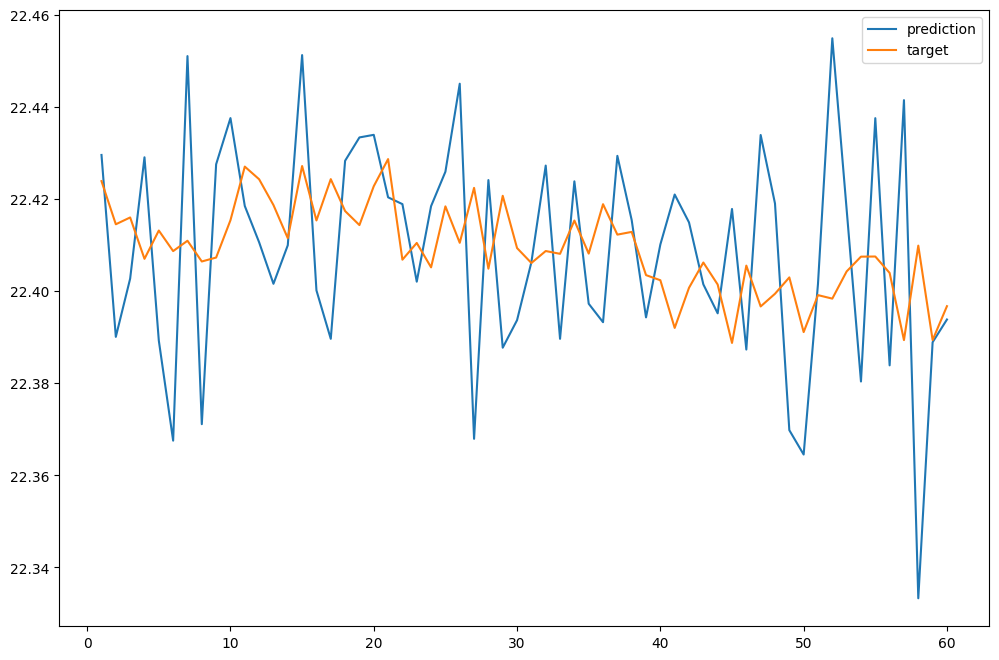

In [42]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[:60],label='prediction')
axes.plot(np.arange(1,61),target[:60],label='target')
axes.legend()

In [44]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.1281883865594864 %


In [45]:
pred_list

[22.4295711517334,
 22.390077590942383,
 22.402719497680664,
 22.429061889648438,
 22.389266967773438,
 22.36754035949707,
 22.45103645324707,
 22.37111473083496,
 22.427541732788086,
 22.437576293945312,
 22.418489456176758,
 22.410612106323242,
 22.401596069335938,
 22.40996551513672,
 22.451255798339844,
 22.400165557861328,
 22.389644622802734,
 22.42830467224121,
 22.43337631225586,
 22.43393898010254,
 22.420372009277344,
 22.418893814086914,
 22.40205192565918,
 22.418455123901367,
 22.42593002319336,
 22.445039749145508,
 22.367935180664062,
 22.424118041992188,
 22.387720108032227,
 22.393699645996094,
 22.406286239624023,
 22.427263259887695,
 22.389646530151367,
 22.42384147644043,
 22.397268295288086,
 22.39325714111328,
 22.42937469482422,
 22.415422439575195,
 22.39430046081543,
 22.410131454467773,
 22.420978546142578,
 22.414920806884766,
 22.401470184326172,
 22.395183563232422,
 22.417842864990234,
 22.387319564819336,
 22.433900833129883,
 22.419034957885742,
 22.369

In [46]:
len(target)

10080

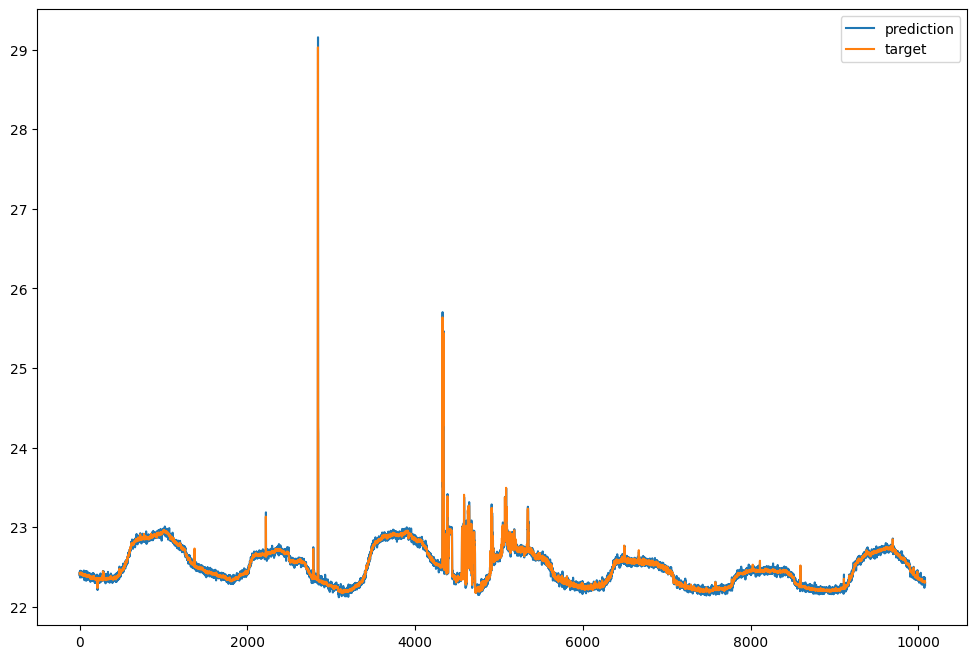

In [47]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

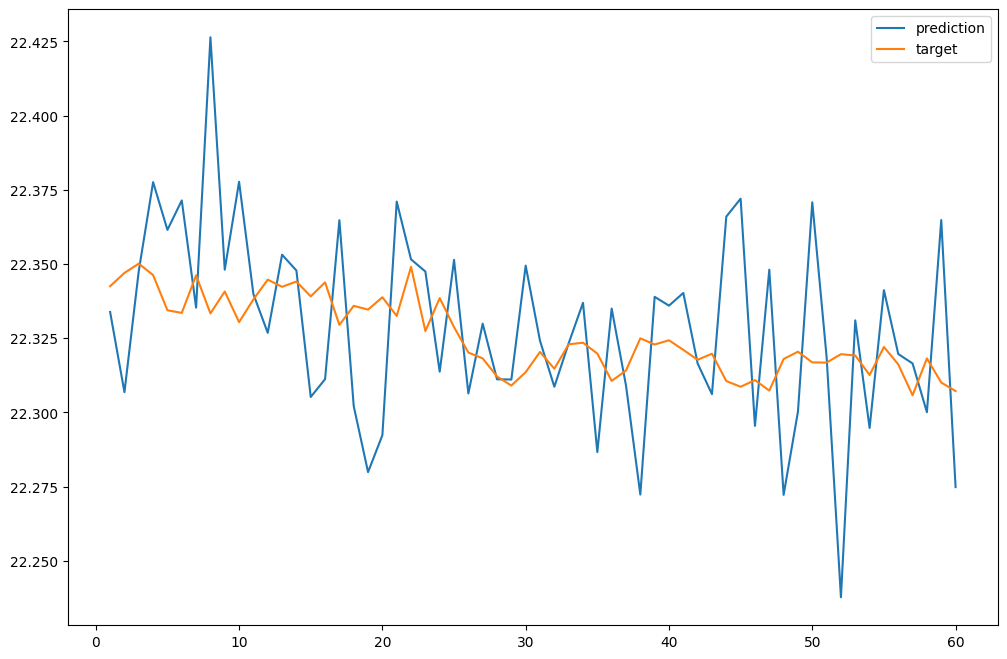

In [48]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [49]:
np.mean(time_list)

0.9843924044853165

1step과 비교했을때level을 맞추면서 sliding을 하게됨

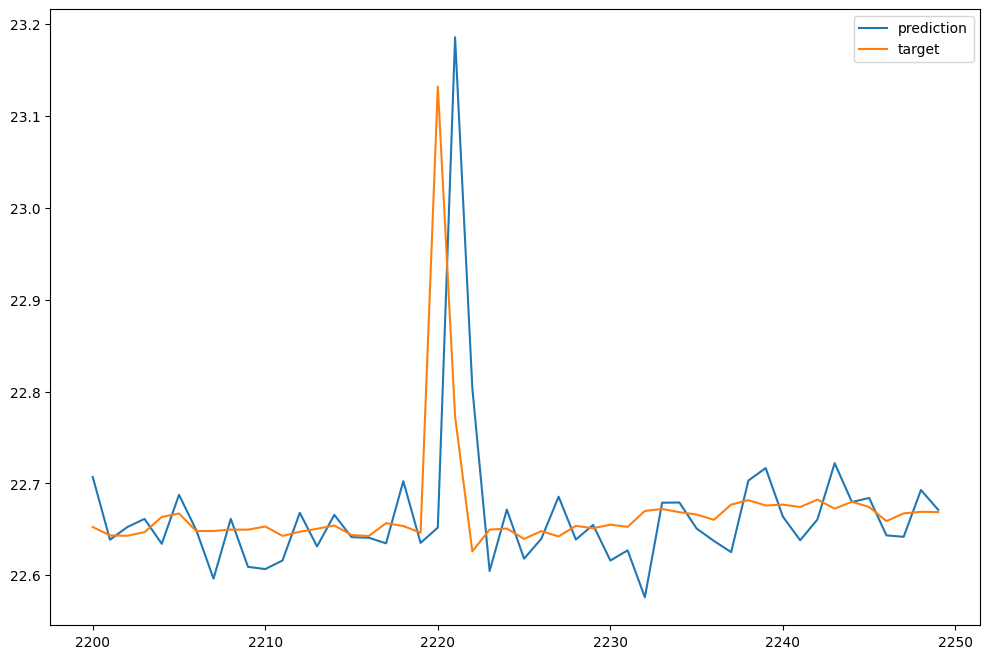

In [50]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()